In [27]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import re
import mglearn
from matplotlib.colors import ListedColormap

# Text Data

Three kinds of features:
* Continous - describe quantity
* Categorical - items from a list (descrete values)
* **Text** - usually just a string

<font color='red'>**Not all string features should be treated as text!**</font>

**String data types**:
* <font color='green'>**Categorical data**</font><br>
    * data from a fixed list
    * confirm it by finding unique values in the dataset
    * possibly compose histogram of words as well
* <font color='green'>**Free strings (semantically mapped to categories)**</font><br>
    * data that is collected by free entry
    * probably best is to convert it to categories, e.g. keep msot popular categories 
* <font color='green'>**Structured string data<br>**</font>
    * e.g. addresses, palce names, dates, phone numbers
* <font color='green'>**Text data**</font>
    * phrases, sentences 
    * e.g. tweets, chat logs, hotel reviews
    
In text analysis:
* **corpus** - text dataset
* **document** - each data point in corpus

## Loading Text Data

Dataset:
* The data is obtained from http://ai.stanford.edu/~amaas/data/sentiment/ and collected by Stanford researcher Andrew Maas from IMDb
* contains text of reviews and labels wether review was "positive" or "negative"
* Binary class classification where rating 1-5 is negative and 6-10 is positive
* training and test datasets are provided in separate folders
* each folder has subfolders, corresponding to positive and negative reviews
* each review has a separate .txt file

<img src="img/text1.png" alt="Drawing" style="width: 100px;"/>

There is a helper function **load_files()** in sklearn to load files in such a file structure, where each subfolder corresponds to a label

In [7]:
rev_train = load_files("data/aclImdb/train/")
rev_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [8]:
# load_files() returns bunch, contains tarining texts & labels
text_train, y_train = rev_train.data, rev_train.target

print('Type of text_train: {}'.format(type(text_train)))
print('Length of text_train: {}'.format(len(text_train)))

Type of text_train: <class 'list'>
Length of text_train: 25000


* Since dataset contained unsupervised data aswell, we disregard it, for now
* Each entry in *text_train* is a string of a review

In [31]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

* These reviews contain some **HTML** code
* Lets clean the reviews from them

In [33]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.  It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see.   Flawed but honest with a terrible honesty."

In [35]:
print('Samples per class (traiing): {}'.format(np.bincount(y_train)))

Samples per class (traiing): [12500 12500]


* the dataset is balanced - equal number of 'neg' and 'pos' reviews
* similarly extract test data

In [37]:
rev_test = load_files("data/aclImdb/test/")
text_test, y_test = rev_test.data, rev_test.target
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]
print('Length of text_test: {}'.format(len(text_test)))
print('Samples per class (testing): {}'.format(np.bincount(y_test)))

Length of text_test: 25000
Samples per class (testing): [12500 12500]


* <font color='red'>**GOAL:**</font> Classify each review as 'pos' or 'neg'
* Text data is not in a proper format

## Formatting Data (Bag-of-Words)

* Sentences need to be split into separate strings
* Each string occurance has to be counted
* Eventually: converting text into numeric

Computing the **bag-of-words** representation for a *corpus* of *documents* steps:
1. **Tokenization**: Splitting (by whitespace & punctuations) raw strings (reviews) into words (*tokens*).
2. **Vocabulary building**: Collect vocabulay of all words in *documents* and **number** them (e.g. alphabetically)
3. **Encoding**: For each *document* and word in it count the word occurance

<img src="img/text2.png" alt="Drawing" style="width: 600px;"/>

**BoW on Toy-Dataset**:

In [40]:
documents = ["The fool doth think he is wise,",
            "but the wise man knows himself to be a fool"]

# initialize CountVectorizer() which tokenizes the strings
# and constructs bag of words (acessed by 'vocabulary_' attr)
c_vec = CountVectorizer().fit(documents)

print('Vocaulary size: {}'.format(len(c_vec.vocabulary_)))
print('Vocabulary content:\n{}'.format(c_vec.vocabulary_))

Vocaulary size: 13
Vocabulary content:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [41]:
bag = c_vec.transform(documents)
print('Bag-of-Words: {}'.format(repr(bag)))

Bag-of-Words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


* The bag-of-words representation is stored in a SciPy sparse matrix 
* The matrix stores only the non-zero entries
* Matrix shape (2, 13), row for each document, column for each word in the vocabulary
* To view the matrix, we convert it to dense NumPy array

In [42]:
print('Dense representation of the bag-of-words:\n{}'.format(
    bag.toarray()))

Dense representation of the bag-of-words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


**BoW on Movie Reviews**

In [46]:
c_vec = CountVectorizer().fit(text_train)
X_train = c_vec.transform(text_train)
feature_names = c_vec.get_feature_names()

print('Vocabulary shape: {}'.format(X_train.shape))
print('Number of features: {}'.format(len(feature_names)))
print('\nEvery 5000nth feature:\n{}'.format(feature_names[::5000]))

Vocabulary shape: (25000, 74849)
Number of features: 74849

Every 5000nth feature:
['00', 'augustine', 'bête', 'cost', 'draper', 'fleece', 'hasan', 'jardine', 'maars', 'nathaniel', 'pincher', 'replica', 'shunning', 'swordmen', 'unproven']


* Let's build our first classifier model 
* With high dimensional sparse data lin models like *LogisticRegression* often work best

In [49]:
scores = cross_val_score(LogisticRegression(), X=X_train, y=y_train, cv=5,
                         n_jobs=-1)
print('Mean cv accuracy: {:.3f}'.format(np.mean(scores)))

Mean cv accuracy: 0.881


* Let's optimize LogisticRegression 'C' paramter with GridSearchCV

In [54]:
X_test = c_vec.transform(text_test)
print('Generalization performance {:.3f}'.format(grid_cv.score(X_test, y_test)))

Generalization performance 0.879


* Performance is already reasonably good
* Let's try to improve the performance

## Dropping Features

* The *CountVectorizer* uses regex for extracting tokens
* The default regex is **"\b\w\w+\b"** - sequence of characters consistng of at least 2 letters **\w**, separated by word boundries **\b**
* It dismisses single letter words 
* It splits up "doesn't" and "bit.ly"
* *CountVectorizer* lowercases all tokens
* we got uninformative fatures like numbers, with the exception of "007"


### Minimum Token Threshold:
* Use features that are represented at least in **X** number of documents (5 ors). 
* Token appearing only in a single or a couple of documents is hardly being helpful for generalization.
* Use **min_df** parameter in CountVectorizer()

In [55]:
c_vec = CountVectorizer(min_df=5).fit(text_train)
X_train = c_vec.transform(text_train)
print('X_train shape: {}'.format(X_train.shape))

X_train shape: (25000, 27271)


* Reduced features from 74849 to 27271
* Lets eyeball some of these features
* Use GridSearchCV and model performance

In [57]:
feature_names = c_vec.get_feature_names()

print('First 50 tokens:\n{}\n'.format(feature_names[:50]))
print('Every 5000th token:\n{}'.format(feature_names[::5000]))

First 50 tokens:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']

Every 5000th token:
['00', 'complicity', 'gaining', 'martin', 'repartee', 'trend']


In [59]:
param_grid = {'C': np.logspace(-2, 2, 5)}

grid_cv = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=10000),
                       param_grid, cv=5, iid=False,
                       return_train_score=False, n_jobs=-1).fit(X_train, y_train)

print('Best cv score: {:.3f}'.format(grid_cv.best_score_))
print('Best parameters: {}'.format(grid_cv.best_params_))

Best cv score: 0.888
Best parameters: {'C': 0.1}


* model accuracy didn't improve 
* model speed increased since we threw away many features

### Maximum Token Threshold

* another way of getting rid of uninformative features is to delete the tokens that are too frequent
* two main strategies:
    * using predefined **stopwords**
    * discarding words by their occuring frequency

#### Stopwords

* **sklearn.feature_extraction.text** module contains English stopwords

In [62]:
print('Number of English stopwords: {}'.format(len(ENGLISH_STOP_WORDS)))
print('\nEvery 20th English stopword:\n{}'.format(list(ENGLISH_STOP_WORDS)[::20]))

Number of English stopwords: 318

Every 20th English stopword:
['onto', 'which', 'along', 'next', 'has', 'some', 'no', 'together', 'between', 'with', 'couldnt', 'several', 'without', 'wherein', 'seeming', 'back']


In [63]:
c_vec = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = c_vec.transform(text_train)

print('X_train shape: {}'.format(X_train.shape))

X_train shape: (25000, 26966)


In [67]:
grid_cv = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000), param_grid=param_grid, 
                       cv=5, iid=False, return_train_score=False, n_jobs=-1).fit(X_train, y_train)

print('Best cv score: {:.3f}'.format(grid_cv.best_score_))

Best cv score: 0.883


#### Max Token Frequency

In [70]:
c_vec = CountVectorizer(min_df=5, max_df=0.45).fit(text_train)
X_train = c_vec.transform(text_train)

grid_cv = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000), param_grid=param_grid, 
                       cv=5, iid=False, return_train_score=False, n_jobs=-1).fit(X_train, y_train)

print('Best cv score: {:.3f}'.format(grid_cv.best_score_))

Best cv score: 0.886


In [71]:
print('X_train.shape: {}'.format(X_train.shape))

X_train.shape: (25000, 27240)


* we eliminated features that were present at least 45% of the data

## Rescaling Features

* instead of dropping features we can rescale them
* **term frequency–inverse document frequency (tf–idf)** is most popular method
* method gives high *weights* to terms that appear often in a particualr *document* but not in many documents in the *corpus*
* two possibilities in sklearn:
    * **TfidfTransformer**
        * Input: Sparse Matrix produced by CountVectorizer
        * Output: Scaled Data with Feature Extraction
    * **TfidVectorizer**
        * Input: Raw text data (does vectorization, scaling)
        * Output: Scaled Data with Feature Extraction
* Both classes apply L2 normalization

In [75]:
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression(solver='lbfgs', max_iter=1000))

param_grid = {'logisticregression__C': np.logspace(-3, 1, 5)}

grid = GridSearchCV(pipe, param_grid, cv=5, iid=False, return_train_score=False,
                   n_jobs=-1).fit(text_train, y_train)

print('Best cv accuracy score: {:.3f}'.format(grid.best_score_))

Best cv accuracy score: 0.892


* Let's inspect the words the TfidfVectorizer found to be most important

In [76]:
tfidf_vec = grid.best_estimator_.named_steps["tfidfvectorizer"]

# transform the training dataset
X_train = tfidf_vec.transform(text_train)

# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(tfidf_vec.get_feature_names())
print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
Features with highest tfidf: 
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


* Features with low tfidf:
    * very commonly used across documents 
    * or only used sparingly
    * or in very long documents.
* Features with high tfidf:
    * only appear in reviews for this particular show or franchise
    * These words are unlikely to help us in our sentiment classification task
    * contain a lot of specific information about the reviews <br>
<br>

* We can also find the words that have low inverse document frequency—that is, those that appear frequently and are therefore deemed less important. 
* The inverse document frequency values found on the training set are stored in the **idf_** attribute:

In [77]:
stored_by_idf = np.argsort(tfidf_vec.idf_)
print("Features with lowest idf:\n{}".format(feature_names[stored_by_idf[:10]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but']


* these are mostly english stopwords
* these might be importatn for sentiment analysis but not for tfidf

## Model Coefficients

* we have 27k coefficents, lets try to extract the top features with highest coefficients in logisticregression

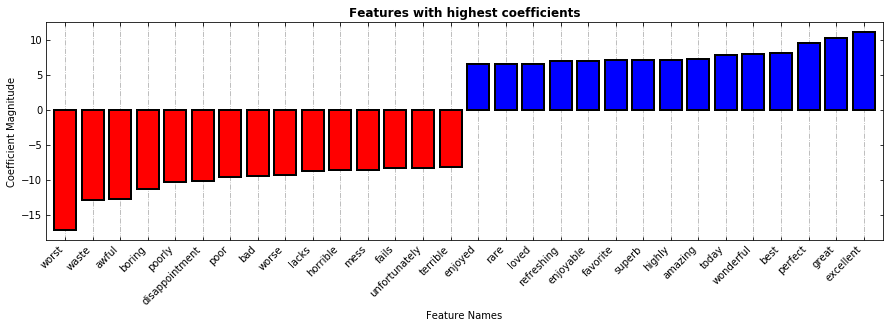

In [158]:
coefs = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()

# coefs with large abs values
max_coefs_args = np.argsort(coefs)[-15:]
min_coefs_args = np.argsort(coefs)[:15]
min_max_coefs_args = np.hstack([min_coefs_args, max_coefs_args])

# plotting the coefs
colors = ["#FF0000" if coef < 0 else '#0000FF' for coef in coefs[min_max_coefs_args]]
feature_names = np.array(feature_names)

plt.figure(figsize=(15, 4))
plt.gca().xaxis.grid(linestyle='-.')
plt.bar(x=np.arange(30), height=coefs[min_max_coefs_args], color=colors, 
       linewidth=2, edgecolor='black', zorder=2)
plt.xticks(ticks=np.arange(0, 2 * 15), labels=feature_names[min_max_coefs], 
           rotation=45, ha="right")
plt.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

plt.xlabel('Feature Names')
plt.ylabel('Coefficient Magnitude')
plt.title('Features with highest coefficients', weight='bold')
plt.margins(x=0.01)
plt.show()

* The negative coefficients on the left belong to words that according to the model are indicative of negative reviews
* the positive coefficients on the right belong to words that according to the model indicate positive reviews.

## Context: n-Grams

* by counting tokens we disrecard the context of it, example
    * "it’s bad, not good at all"
    * "it’s good, not bad at all"
* these will yield in same results, while meaning opposite things
* context can be captured if we do not separate only individual words but also pair-wise or triplets
* sequence of tokens are called **n-grams**
* need to specify **ngram_range** parameter in *CountVectorizer* or *TfidfVectorizer*

**On toy dataset**:

In [159]:
docs = ['The fool dont think he is wise,',
             'but the wise man knows himself to be a fool']

tf_vec = TfidfVectorizer(ngram_range=(1, 3)).fit(docs)

print('Vocabulary size: {}'.format(len(tf_vec.vocabulary_)))
print('\nVocabulary:\n{}'.format(tf_vec.get_feature_names()))

Vocabulary size: 39

Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'dont', 'dont think', 'dont think he', 'fool', 'fool dont', 'fool dont think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool dont', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


**Lets try to figure out the best n-gram representation for IMDb dataset with GridSearchCV**

In [164]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), 
                     LogisticRegression(max_iter=1000, solver='lbfgs'))

param_grid = {'tfidfvectorizer__ngram_range': [(1,1), (1, 2), (1, 3)],
              'logisticregression__C': np.logspace(-2, 1, 4)}

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=False,
                    iid=False, n_jobs=-1).fit(text_train, y_train)

print('Best cv score: {:.3f}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best cv score: 0.906
Best parameters: {'logisticregression__C': 10.0, 'tfidfvectorizer__ngram_range': (1, 3)}


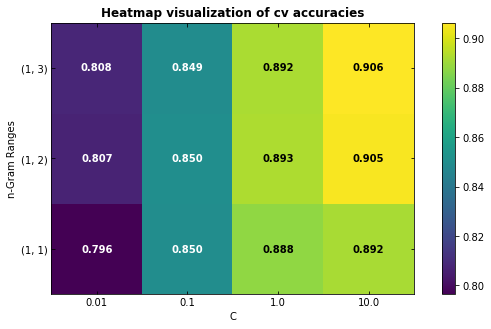

In [185]:
# extract accuracy scores and transpose the array
acc_scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T

# construct heatmap
plt.figure(figsize=(10, 5))
ax = plt.gca()
img = ax.pcolor(acc_scores, cmap='viridis')
img.update_scalarmappable()
ax.set_xlabel('C')
ax.set_ylabel('n-Gram Ranges')
ax.set_xticks(np.arange(len(param_grid['logisticregression__C'])) + .5)
ax.set_yticks(np.arange(len(param_grid['tfidfvectorizer__ngram_range'])) + .5)
ax.set_xticklabels(param_grid['logisticregression__C'])
ax.set_yticklabels(param_grid['tfidfvectorizer__ngram_range'])
ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
ax.set_title('Heatmap visualization of cv accuracies', weight='bold')
ax.set_aspect(1)
# construct values on top of heatmap so they are easily readable
for patch, color, value in zip(img.get_paths(), 
                               img.get_facecolors(),
                               img.get_array()):
    
    x, y = patch.vertices[:-2, :].mean(0)
    if np.mean(color[:3]) > 0.5:
        c = 'k'
    else:
        c = 'w'
    ax.text(x, y, "%0.3f" % value, color=c, ha="center", va="center", weight='bold')
plt.colorbar(img)
plt.show()

* Using bigrams increased model accuracy by 1%
* Trigrams basically didn't alter the model accuracy anymore
* Lets visualize top features with highest coeffiecnts

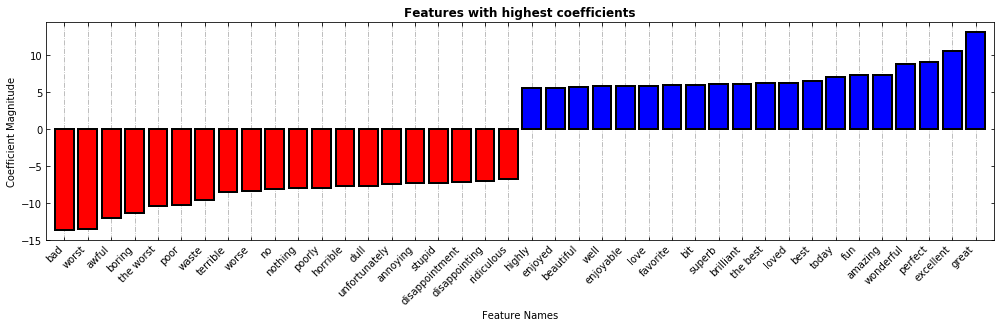

In [210]:
tf_vec = grid.best_estimator_.named_steps['tfidfvectorizer']

feature_names = np.array(tf_vec.get_feature_names())
coefs = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()

# coefs with large abs values
max_coefs_args = np.argsort(coefs)[-20:]
min_coefs_args = np.argsort(coefs)[:20]
min_max_coefs_args = np.hstack([min_coefs_args, max_coefs_args])

# plotting the coefs
colors = ["#FF0000" if coef < 0 else '#0000FF' for coef in coefs[min_max_coefs_args]]

plt.figure(figsize=(17, 4))
plt.gca().xaxis.grid(linestyle='-.')
plt.bar(x=np.arange(40), height=coefs[min_max_coefs_args], color=colors,
        linewidth=2, edgecolor='black', zorder=2)
plt.xticks(ticks=np.arange(0, 2 * 20), labels=feature_names[min_max_coefs_args],
           rotation=45, ha="right")
plt.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

plt.xlabel('Feature Names')
plt.ylabel('Coefficient Magnitude')
plt.title('Features with highest coefficients', weight='bold')
plt.margins(x=0.01)
plt.show()

## Stemming & Lemmatization

* Tokenization cannot make difference in suffixes: "replace", "replacing", "replacement", "replaced" etc
* So tokenization counts each word by its own - thus increasing model overfitting
* By capturing word **stems** this probelm can be solved
* **Stemming** - a rule-based heuristic, dropping common suffixes
* **Lemmatization** - an explicit human-verified dictionary of known word forms, also taking into account the role of the word
* **lemma** - a standardized form of the word
* Both processes (stemming & lemmatization) are forms of *normalization*
* Another normalization form is spelling correction

### Porter Stemmer

* compare stemming (nltk package) and lemmatization (spacy package)

In [3]:
# load spacy's English-language models
en_nlp = spacy.load('en')

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    
    # print tokens found by Porter stemmer
    print("\nStemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])
    
sentence = u"Our meeting today was worse than yesterday, \
    I'm scared of meeting the clients tomorrow."

compare_normalization(sentence)

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '    ', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']

Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', '    ', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


* lemmatization detected words and changed to their base verb form:
    * was, I'm $\rightarrow$ *be*
    * *worse* $\rightarrow$ *bad*
    * *meeting* $\rightarrow$ *meet*
    * *clients* $\rightarrow$ *client*
* lemmatization detects first "*meeting*" as noun and leaves it as it is, the other one as a verb and changes to its base verb form
* stemming trims the words:
    * *meeting* $\rightarrow$ *meet*
    * *was* $\rightarrow$ *wa*
    * *worse* $\rightarrow$ *wors*
* in general lemmatization produces better results than word stemming
* by default sklearn doesn't implement neither normalization it can be brought into *CountVectorizer* with **tokenizer** parameter

### Lemmatization with Spacy

* we want to use lemmatization from spacy
* we need to replace spacy tokenizer with regex-based tokenization

In [12]:
# CountVectorizer default regex-python. (?u) - matches chars by unicode,
# probably redundant in Python 3
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy english language model, save old tokenizer
en_nlp = spacy.load('en')
old_tokenizer = en_nlp.tokenizer
# replace spacy tokenizer with regexp based tokenizer
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# define our custom tokenizer
def lemma_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define CountVectorizer with spacy lemmatization
lemma_vec = CountVectorizer(tokenizer=lemma_tokenizer, min_df=5)

In [13]:
# transform our imdb reviews with lemma_vec
X_train_lemma = lemma_vec.fit_transform(text_train)
print("X_train_lemma shape: {}".format(X_train_lemma.shape))

# build standard CountVectorizer for comparison
c_vec = CountVectorizer(min_df=5).fit(text_train)
X_train = c_vec.transform(text_train)
print("X_train shape: {}".format(X_train.shape))

X_train_lemma shape: (25000, 21543)
X_train shape: (25000, 27272)


* lemmatization reduced 6000 features
* lets comapre lemmatizier model with regular one
* lets use only 1% of the data for training since lemmatization works well when the sample size is small

In [18]:
param_grid = {'C': np.logspace(2,-2, 5)}

cross_v = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01,
                            random_state=0)

grid_cv = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000), param_grid, cv=cross_v,
                       iid=False, return_train_score=False, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print("Best cv score (default CountVectorizer): {:.3f}".format(grid_cv.best_score_))

grid_cv.fit(X_train_lemma, y_train)
print("Best cv score (lemmatization): {:.3f}".format(grid_cv.best_score_))

Best cv score (default CountVectorizer): 0.717
Best cv score (lemmatization): 0.731


* lemmatization gave minor increase in model performance
* the result depends on datasets

## Topic Modelling & Document Clustering

* **Topic modelling** - assigning a document to a or multiple topics, usually unsupervised. 
* **Document Clustering** - each document is categorized into single class.
* If document can belong to more than 1 topic, the task relates to decomposition problem.
* Document consists then with components, each corresponding to particualr topic with some (coefficient) strength
* **Latent Dirichlet Allocation** - decompositon mehtod for topic modelling

### Latent Dirichlet Allocation (LDA)

* tries to capture group of words (topics) that appear frequently together
* each document is seen as mixture of topics
* topics captured by decomposition algorithms might not have a semantic meaning
* lets apply LDA on IMDb data
* for unsupervised models it is good practice to remove very common words, since they tend to dominate the results
* lets remove words that appear at least in 1/5 th of the documents 
* also limit the BoW to top 10k words

In [23]:
c_vec = CountVectorizer(max_df=.20, max_features=10000)
X_unsup = c_vec.fit_transform(text_train)

* lets say we have 10 different topics
* as for Non-negative Matrix Factorization, topics aren't ordered in any way 
* changing the number of topics will change all the topics
* we could also use NMF for this matter

In [26]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch',
                                random_state=0, max_iter=30, n_jobs=-1)

topics = lda.fit_transform(X_unsup)

* lets print 10 most important words from each topic

In [28]:
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(c_vec.get_feature_names())

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
films         show          your          role          action        
such          love          why           cast          effects       
world         funny         know          performance   films         
these         series        ever          character     scenes        
us            tv            did           best          budget        
work          best          ve            actor         horror        
life          still         thing         actors        special       
those         episode       say           play          pretty        
cinema        years         something     performances  low           
yet           saw           didn          plays         better        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

* since we used only 10 topics, the topics are very broad
* the word *horror* was captured in topic 4 and 5
* we could specifiy more topics and see how the data is distributed then
* we skip this since this process is quite slow
* topic 7 seems to be moview reviews abot musical plays, let's check if this is the case 

In [39]:
# sort by weight of "music" topic 7
music = np.argsort(topics[:, 7])[::-1]

# print the five documents where the topic is most important
for i in music[:5]:
    # show first two sentences
    print(b".".join(text_train[i].split(b".")[:2]))

b'This film is a jolt of punk rock fun, from start to finish. The Ramones, reigning princes of late-70s Punk rock, appear as themselves'
b'Of course, the story line for this movie isn\'t the best, but the dances are wonderful. This story line is different from other Astaire-Rogers movies in that neither one is "chasing" the other'
b'One of the best of the Fred Astaire and Giner Rogers films. Great music by Irving Berlin'
b'Errol Flynn is "Gentleman Jim" in this 1942 film about boxer Jim Corbett, known as the man who beat John L. Sullivan'
b'Astaire and Rogers at the height of their popularity. In 1936 Americans thought of the Navy as a place for song and dance'


* we can also visualize how much weight each topic gets overall
* lets name each topic by their 2 most common workds

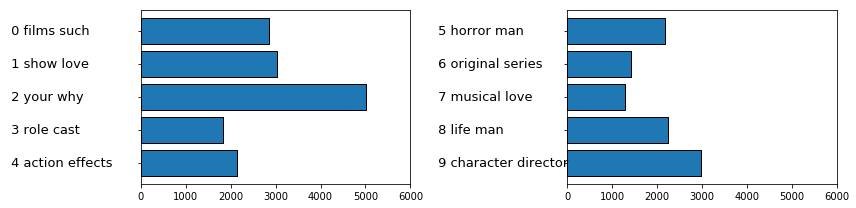

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
topic_names = ["{:>2} ".format(i) + " ".join(words) 
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 5
    end = (col + 1) * 5
    ax[col].barh(np.arange(5), np.sum(topics, axis=0)[start:end], edgecolor='k', lw=1)
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="center", fontsize=13)
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 6000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()